<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Intro to CNNs and DNNs

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function

## Video Tutorial
[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

## Deliverable
For this lab, you will submit an ipython notebook via learningsuite.
This is where you build your first deep neural network!

For this lab, we'll be combining several different concepts that we've covered during class,
including new layer types, initialization strategies, and an understanding of convolutions.

## Grading Standards:
* 30% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___

### Part 0
Watch and follow video tutorial:

[https://youtu.be/3TAuTcx-VCc](https://youtu.be/3TAuTcx-VCc)

**TODO:**

**DONE:**

* Watch tutorial

In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import math

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

**TODO:**

**DONE:**
* CrossEntropyLoss 
* Conv2D

___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.
You can specify which strategy you want to use with a parameter. 



Helpful links include:
*  [Orthogonal Initialization](https://hjweide.github.io/orthogonal-initialization-in-convolutional-layers) (or the original paper: http://arxiv.org/abs/1312.6120)
*  http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization

**TODO:**

**DONE:**

* Parameterize custom Conv2D for different initilization strategies
* Xe
* Orthogonal
* Uniform



In [63]:
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight = None, size_average=None, ignore_index = -100, 
                 reduce = None, reduction = 'mean'):
        super(CrossEntropyLoss, self).__init__()
        self.weight = weight
        self.ignore_index = ignore_index
    
    def forward(self, input, target):
        log_soft = F.log_softmax(input, 1)
        return F.nll_loss(log_soft, target, weight=self.weight, ignore_index=self.ignore_index)


class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, weight_init='xavier', stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
        self.__dict__.update(locals()) # Make all the above params part of the class
        super(Conv2d, self).__init__()

        # weight should be size: (out, in, k, k) where k is kernel size
        self.weight = Parameter(torch.Tensor(self.out_channels, 
                                    self.in_channels, 
                                    *self.kernel_size))
        # bias should be size: (out)
        self.bias = Parameter(torch.Tensor(self.out_channels))

        # Initialize the weights and bias
        if self.weight_init == 'xavier':
            num_in = self.weight.data.size(1)
            num_out = self.weight.data.size(0)
            std_dev = math.sqrt(2.0 / float(num_in + num_out))
            mean = 0.0
            self.weight.data.normal_(mean, std_dev)

        elif self.weight_init == 'orthogonal':
            expected_shape = (self.out_channels,
                              self.in_channels,
                              *self.kernel_size)
            flat_shape = (self.out_channels,
                          self.in_channels * self.kernel_size[0] * self.kernel_size[1])
            x = np.random.normal(0.0, 1.0, flat_shape)
            # Use singular value decomposition to get two orthogonal matrices
            U, _, V = np.linalg.svd(x, full_matrices=False)
            # Pick the matrix with the correct shape
            weights = U if U.shape == flat_shape else V
            weights = weights.reshape(expected_shape)
            self.weight.data = torch.from_numpy(weights).float()

        elif self.weight_init == 'uniform':
            self.weight.data.uniform_(-1, 1)

        # Init bias to numbers between [0 and 1)
        self.bias.data = torch.rand(*self.bias.data.size())

    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)



In [3]:
class ConvNetwork(nn.Module):
    def __init__(self, dataset, weight_init_method='xavier'):
        super(ConvNetwork, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size() # channel, height, width of image
        out = 10
        default_kernel_size = (3,3)

        self.net = nn.Sequential(
            Conv2d(c, out, kernel_size=default_kernel_size, padding=(1,1), weight_init=weight_init_method),
            nn.ReLU(),
            Conv2d(out, out, kernel_size=(h, w), padding=(0,0), weight_init=weight_init_method),
        )

    def forward(self, x):
        # self.net returns -> (n, out, 1, 1), squeeze removes the last two dimensions
        return self.net(x).squeeze(2).squeeze(2)


# Use the dataset class you created in lab2
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root, 
                                          train=train, 
                                          transform=transforms.ToTensor(),
                                          download=True)

    def __getitem__(self, idx):
        x, y = self.data[idx]
        return x, y

    def __len__(self):
        return len(self.data)


In [50]:
# Training loop
def train(model, loss_func, optimizer, train_loader, val_loader, num_epochs, check_val_step=500):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        loop = tqdm(total=len(train_loader), position=0, leave=False)

        # Train through all the batches
        train_loss_list = []
        train_acc_list = []
        for batch, (x, y_truth) in enumerate(train_loader):
            x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True) # non_blocking is a speed up (async)
            
            optimizer.zero_grad() # Set gradient to zero

            y_hat = model(x)
            loss = loss_func(y_hat, y_truth)
            train_loss_list.append(loss.item())

            probs = y_hat.argmax(1)
            accuracy = (probs == y_truth).float().mean()
            train_acc_list.append(accuracy.item())

            loop.set_description('epoch {} -> loss: {:.4f}, accuracy: {:.4f}'.format(epoch, loss.item(), accuracy.item()))
            loop.update(1)

            loss.backward() # Compute gradient, for weight with respect to loss
            optimizer.step() # Take step in the direction of the negative gradient
        loop.close()

        # Check model accuracy and loss on validation set
        val_loss_list = []
        val_acc_list = []
        for val_x, val_y in val_loader:
            val_y_hat, val_y_truth = model(val_x.cuda()), val_y.cuda()
            val_loss_list.append(loss_func(val_y_hat, val_y_truth).item())

            val_probs = val_y_hat.argmax(1)
            val_accuracy = (val_probs == val_y_truth).float().mean()
            val_acc_list.append(val_accuracy.item())


        train_losses.append(np.mean(train_loss_list))
        val_losses.append(np.mean(val_loss_list))
        train_accuracies.append(np.mean(train_acc_list) * 100)
        val_accuracies.append(np.mean(val_acc_list) * 100)

    return  train_losses, val_losses, train_accuracies, val_accuracies


In [82]:
def tensor_as_np_img(tensor):
    tensor = tensor / 2 + 0.5
    return tensor.numpy()

def show_tensor_img(tensor):
    img = tensor_as_np_img(tensor)
    plt_img = np.transpose(img, (1, 2, 0))
    if (plt_img.shape[2] < 2):
        plt.imshow(plt_img.squeeze() * 255, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(plt_img)
    plt.show()

def show_loss_graph(title, train_losses, val_losses):
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title(title)
    plt.ylabel("Avg. Loss per epoch")
    plt.xlabel("Epochs")
    plt.ylim([0, max(max(train_losses), max(val_losses))])
    plt.xlim([0, len(train_losses)])
    plt.legend()
    plt.show()

def show_accuracy_graph(title, train_acc, val_acc):
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title(title)
    plt.ylabel("Avg. Accuracy per epoch (%)")
    plt.xlabel("Epochs")
    plt.ylim([0, 100])
    plt.xlim([0, len(train_acc)])
    plt.legend()
    plt.show()

In [44]:
# Instantiate data sets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

# Instantiate your data loaders
train_loader = DataLoader(train_dataset, # You can change the way batches are shuffled here
                          batch_size=42, # Multiple threads
                          pin_memory=True) # Speed improvement param, use same block of GPU memory
val_loader = DataLoader(val_dataset,
                        batch_size=42,
                        pin_memory=True)

In [55]:
xav_model = ConvNetwork(train_dataset, weight_init_method='xavier')
xav_model = xav_model.cuda() # Move to GPU memory

orth_model = ConvNetwork(train_dataset, weight_init_method='orthogonal')
orth_model = orth_model.cuda()

uni_model = ConvNetwork(train_dataset, weight_init_method='uniform')
uni_model = uni_model.cuda()

In [87]:
# Instantiate loss and optimizer functions
xav_loss_func = CrossEntropyLoss()
orth_loss_func = CrossEntropyLoss()
uni_loss_func = CrossEntropyLoss()
xav_optimizer = optim.Adam(xav_model.parameters(), lr=1e-4)
orth_optimizer = optim.Adam(orth_model.parameters(), lr=1e-4)
uni_optimizer = optim.Adam(uni_model.parameters(), lr=1e-4)

num_epochs = 20

In [57]:
# Try a few different networks and initialization strategies
# Xavier
xav_train_losses, xav_val_losses, xav_train_acc, xav_val_acc = train(xav_model, xav_loss_func, xav_optimizer, train_loader, val_loader, num_epochs)

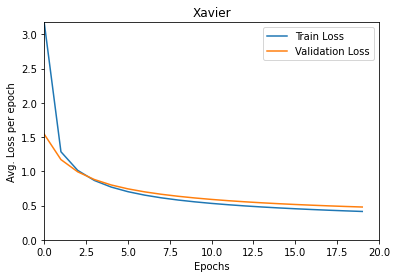

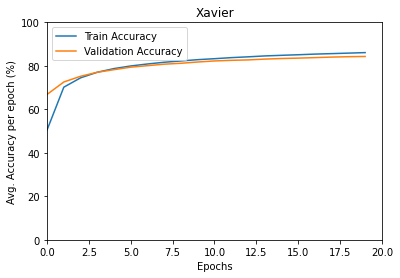

In [83]:
show_loss_graph('Xavier', xav_train_losses, xav_val_losses)
show_accuracy_graph('Xavier', xav_train_acc, xav_val_acc)

In [68]:
# Orthogonal
orth_train_losses, orth_val_losses, orth_train_acc, orth_val_acc = train(orth_model, orth_loss_func, orth_optimizer, train_loader, val_loader, num_epochs)

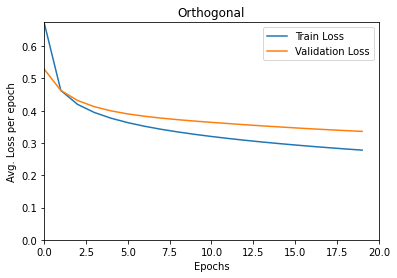

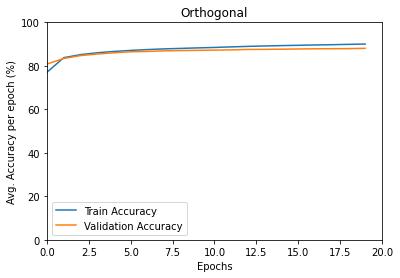

In [85]:
show_loss_graph('Orthogonal', orth_train_losses, orth_val_losses)
show_accuracy_graph('Orthogonal', orth_train_acc, orth_val_acc)

In [72]:
# Uniform
uni_train_losses, uni_val_losses, uni_train_acc, uni_val_acc = train(uni_model, uni_loss_func, uni_optimizer, train_loader, val_loader, num_epochs)

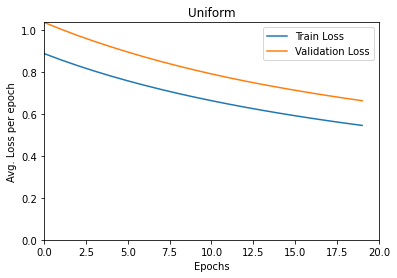

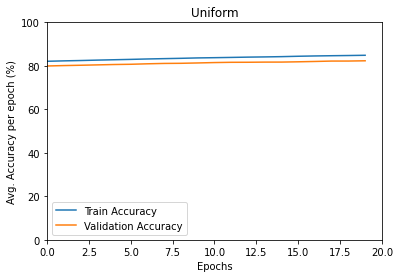

In [84]:
show_loss_graph('Uniform', uni_train_losses, uni_val_losses)
show_accuracy_graph('Uniform', uni_train_acc, uni_val_acc)


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

**TODO:**

**DONE:**
* Experiment with Deep Networks
* Print out number of parameters in the model 
* Plot accuracy of training and validation set over time


In [ ]:

# Go back up and try a few different networks and initialization strategies
# Plot loss if you want
# Plot accuracy



In [86]:
# Compute and print the number of parameters in the model

num_params = sum(p.numel() for p in xav_model.parameters())
print(f'# of params: {num_params}')


# of params: 78510


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3,3), padding=(1,1))**
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : **(out_channels=65, kernel_size=(3,3), padding=(2,2))**
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : **(out_channels=7, kernel_size=(3,3), padding=(6,6))**

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5,5), padding=(2,2))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5,5), padding=(3,3))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5,5), padding=(9,9))**

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : **(out_channels=10, kernel_size=(5, 3), padding=(1, 0))**
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : **(out_channels=100, kernel_size=(5,3), padding=(2,1))**
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : **(out_channels=23, kernel_size=(5,3), padding=(3,2))**
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : **(out_channels=5, kernel_size=(5,3), padding=(9,8))**

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : **(out_channels=10, kernel_size=(4,4), padding=(1,0))**
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : **(out_channels=22, kernel_size=(3,3), padding=(1,1))**

**TODO:**

**DONE:**

* Answer all the questions above 


In [ ]:
input = torch.zeros(1, 3, 10, 10)
# Kernel size (3,3)
k1_size = (3,3)
c = nn.Conv2d(3, 10, kernel_size=k1_size, padding=(0,0))
print(c(input).size())

c = nn.Conv2d(3, 22, kernel_size=k1_size, padding=(1,1))
print(c(input).size())

c = nn.Conv2d(3, 65, kernel_size=k1_size, padding=(2,2))
print(c(input).size())

c = nn.Conv2d(3, 7, kernel_size=k1_size, padding=(6,6))
print(c(input).size())
print('\n')

# Kernel size (5,5)
k2_size = (5,5)
c = nn.Conv2d(3, 10, kernel_size=k2_size, padding=(1,1))
print(c(input).size())

c = nn.Conv2d(3, 100, kernel_size=k2_size, padding=(2,2))
print(c(input).size())

c = nn.Conv2d(3, 23, kernel_size=k2_size, padding=(3,3))
print(c(input).size())

c = nn.Conv2d(3, 5, kernel_size=k2_size, padding=(9,9))
print(c(input).size())
print('\n')


# Kernel size (5,3)
k3_size = (5,3)
c = nn.Conv2d(3, 10, kernel_size=k3_size, padding=(1,0))
print(c(input).size())

c = nn.Conv2d(3, 100, kernel_size=k3_size, padding=(2,1))
print(c(input).size())

c = nn.Conv2d(3, 23, kernel_size=k3_size, padding=(3,2))
print(c(input).size())

c = nn.Conv2d(3, 5, kernel_size=k3_size, padding=(9,8))
print(c(input).size())
print('\n')

# Figure out the kernel size needed
k4_size = (4,4)
c = nn.Conv2d(3, 10, kernel_size=k4_size, padding=(1,0))
print(c(input).size())

k5_size = (3,3)
c = nn.Conv2d(3, 22, kernel_size=k4_size, padding=(1,1))
print(c(input).size())

torch.Size([1, 10, 8, 8])
torch.Size([1, 22, 10, 10])
torch.Size([1, 65, 12, 12])
torch.Size([1, 7, 20, 20])


torch.Size([1, 10, 8, 8])
torch.Size([1, 100, 10, 10])
torch.Size([1, 23, 12, 12])
torch.Size([1, 5, 24, 24])


torch.Size([1, 10, 8, 8])
torch.Size([1, 100, 10, 10])
torch.Size([1, 23, 12, 12])
torch.Size([1, 5, 24, 24])


torch.Size([1, 10, 9, 7])
torch.Size([1, 22, 9, 9])
